In [1]:
try:
    from ultralytics import YOLO
except ImportError:
    !pip install ultralytics
    import os
    os.kill(os.getpid(), 9)
from google.colab import drive
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import yaml

In [2]:
drive.mount('/content/drive/',)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [56]:
!rm -rf /content/"FOR TEST"

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [58]:
!unzip -q -d /content/ "/content/drive/MyDrive/FOR TEST.zip" "*/*"

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [4]:
# กำหนด HOME directory บน Colab
%cd /content/FOR\ TEST
HOME = os.getcwd()

/content/FOR TEST


In [5]:
# โหลดไฟล์ YAML เพื่อกำหนด path ของ test set
def load_yaml(yaml_path):
    with open(yaml_path, "r") as file:
        data = yaml.safe_load(file)
    return data

yaml_config = load_yaml("data.yaml")  # เปลี่ยนเป็น path ของไฟล์ YAML
TEST_PATH = os.path.join(HOME, "test", "images") # ใช้ path จาก YAML

In [6]:
# โหลดข้อมูลการเทรนจาก CSV
csv_files = {
    "model yolo8n": "results8.csv",
    "model yolo11x": "results11.csv",
    "model yolo12x": "results12.csv"
}

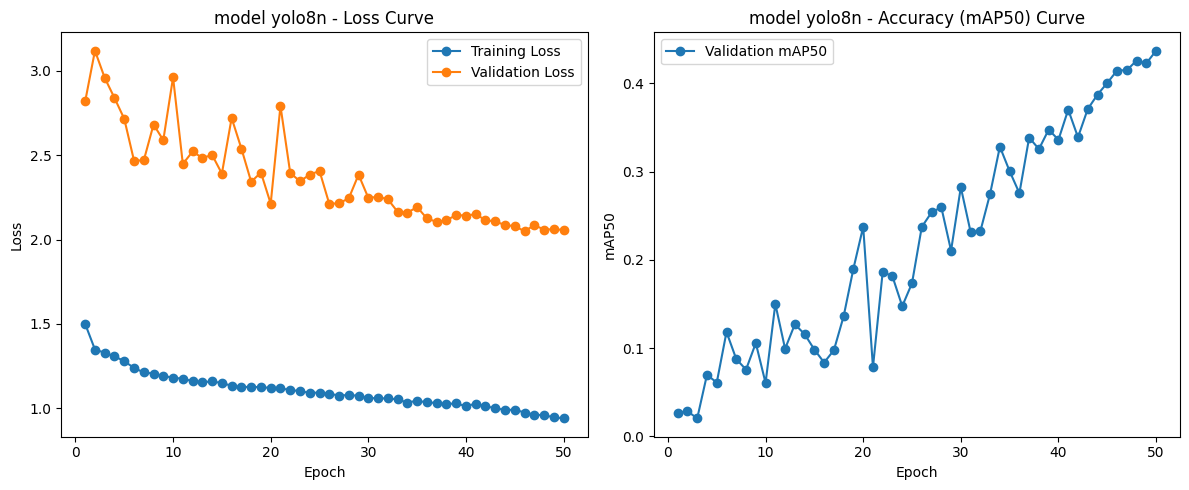

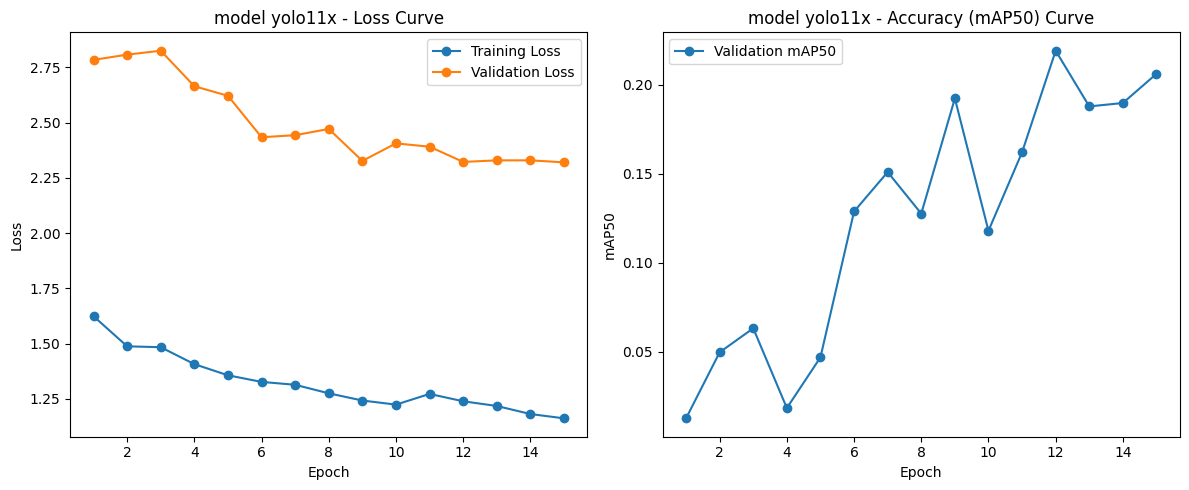

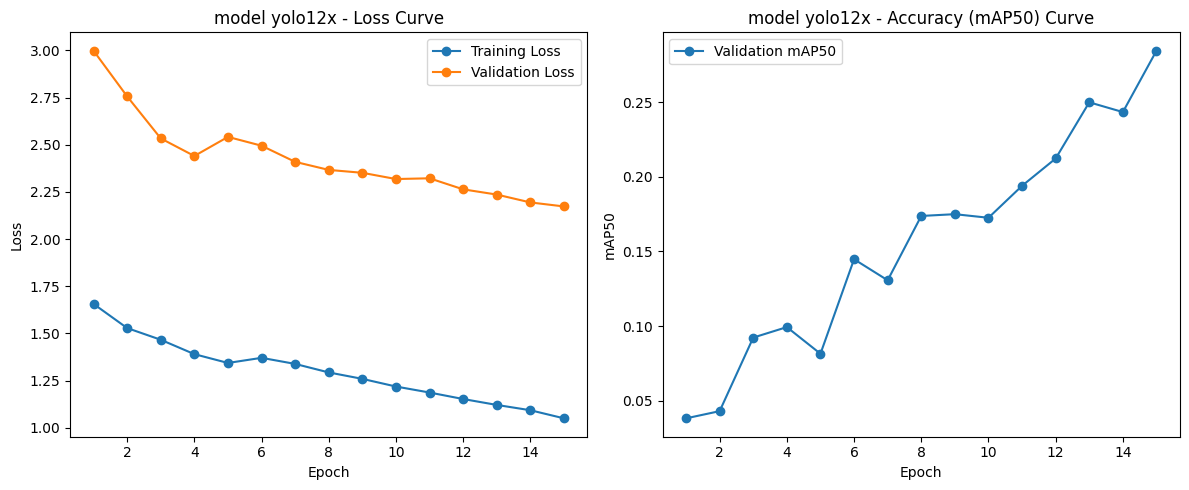

In [7]:
def plot_learning_curve(csv_file, model_name):
    df = pd.read_csv(csv_file)
    plt.figure(figsize=(12, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Training Loss', marker='o')
    plt.plot(df['epoch'], df['val/box_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.legend()

    # Plot Accuracy Curve (ใช้ mAP50 เป็นตัวแทน Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='Validation mAP50', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('mAP50')
    plt.title(f'{model_name} - Accuracy (mAP50) Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

for model_name, file in csv_files.items():
    plot_learning_curve(file, model_name)

In [30]:
# โหลดโมเดลและสร้าง Confusion Matrix
models = {
    "model yolo8n": YOLO("bestyolo8.pt"),
    "model yolo11x": YOLO("bestyolo11.pt"),
    "model yolo12x": YOLO("bestyolo12.pt")
}
class_labels = ['fire', 'smoke']


Evaluating model: model yolo8n


Processing model yolo8n: 100%|██████████| 637/637 [00:13<00:00, 45.87it/s]


Confusion Matrix for model yolo8n:
[[584 116]
 [523 118]]
Overall Accuracy: 0.5235
Precision: 0.5159
Recall: 0.5092
F1 Score: 0.4580
mAP: 0.4580
Class Accuracy: [    0.83429     0.18409]
Calculated Overall Accuracy: 0.5235


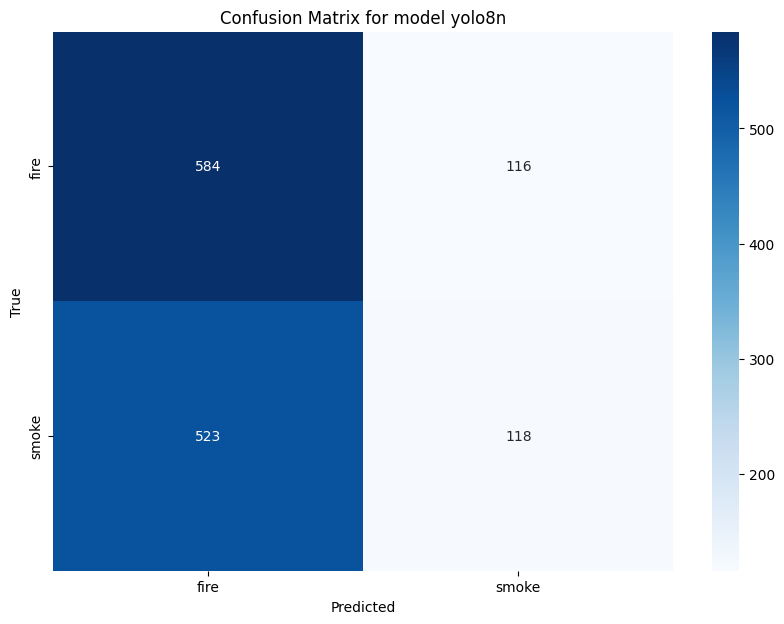


Evaluating model: model yolo11x


Processing model yolo11x: 100%|██████████| 637/637 [00:21<00:00, 30.31it/s]


Confusion Matrix for model yolo11x:
[[754  26]
 [680  25]]
Overall Accuracy: 0.5246
Precision: 0.5080
Recall: 0.5011
F1 Score: 0.3736
mAP: 0.3736
Class Accuracy: [    0.96667    0.035461]
Calculated Overall Accuracy: 0.5246


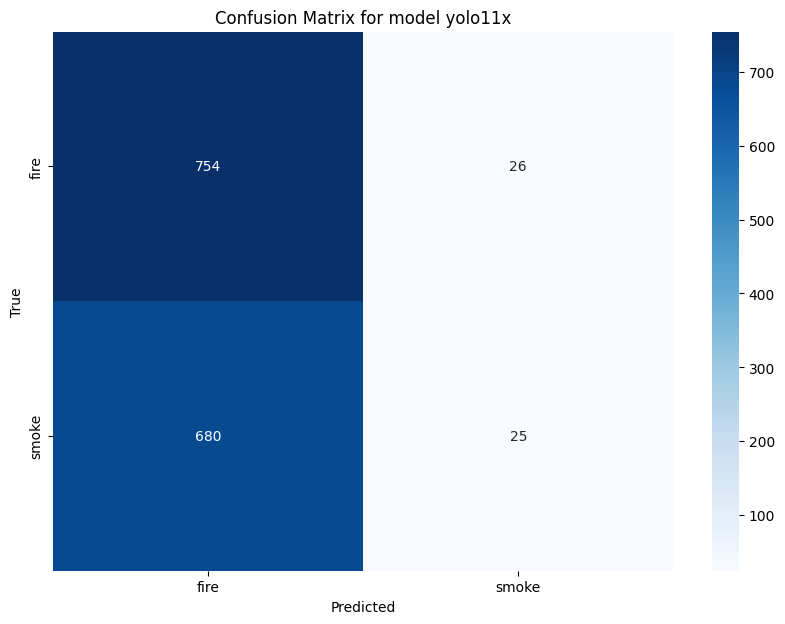


Evaluating model: model yolo12x


Processing model yolo12x: 100%|██████████| 637/637 [00:26<00:00, 23.77it/s]


Confusion Matrix for model yolo12x:
[[691  60]
 [643  40]]
Overall Accuracy: 0.5098
Precision: 0.4590
Recall: 0.4893
F1 Score: 0.3825
mAP: 0.3825
Class Accuracy: [    0.92011    0.058565]
Calculated Overall Accuracy: 0.5098


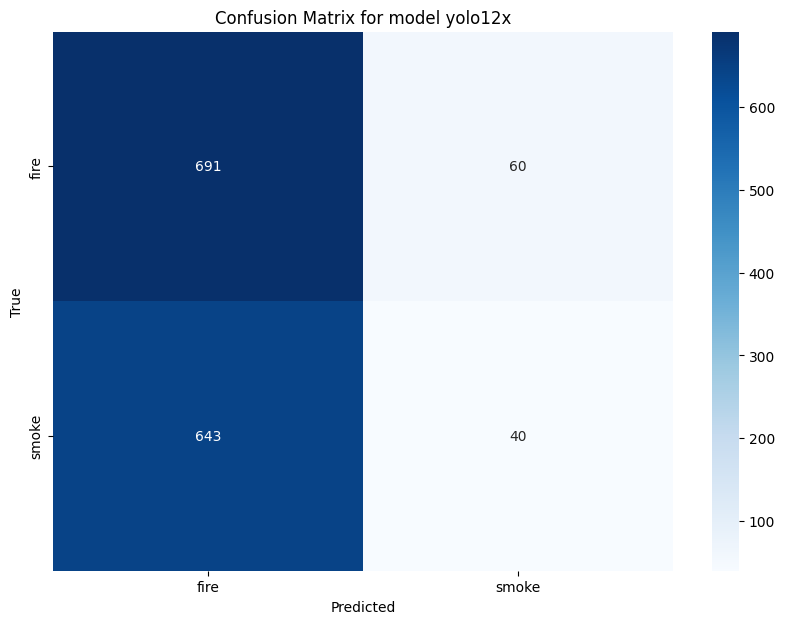

In [60]:
# ฟังก์ชันในการอ่านภาพและการทำนาย
def process_predictions(image, model, label_path):
    # ทำนาย
    predictions = model.predict(image, verbose=False)
    # อ่าน label จริงจากไฟล์
    true_labels = read_labels(label_path)

    # ถ้าไม่มีการทำนาย ให้เติม pred_labels ด้วย 0 (หมายถึงไม่พบการตรวจจับ)
    if not predictions[0].boxes:
        pred_labels = [0] * len(true_labels)  # เติม 0 สำหรับทุก label ที่ไม่มีการทำนาย
    else:
        pred_labels = [int(label) for label in predictions[0].boxes.cls.tolist()]

    return true_labels, pred_labels

# ฟังก์ชันตรวจสอบขนาดของ y_true และ y_pred
def check_consistent_length(y_true, y_pred):
    if len(y_true) != len(y_pred):
        print(f"Warning: The number of ground truth labels ({len(y_true)}) does not match the number of predictions ({len(y_pred)})")
        # ตรวจสอบเพื่อให้แน่ใจว่า length ตรงกัน
        min_length = min(len(y_true), len(y_pred))
        y_true = y_true[:min_length]
        y_pred = y_pred[:min_length]
    return y_true, y_pred

# คำนวณ mAP (mean Average Precision)
def calculate_map(y_true, y_pred, class_count):
    # mAP คำนวณจากค่า precision ที่หลากหลาย thresholds
    ap = []
    for c in range(class_count):
        true_positive = sum([1 for t, p in zip(y_true, y_pred) if t == c and p == c])
        false_positive = sum([1 for t, p in zip(y_true, y_pred) if t != c and p == c])
        false_negative = sum([1 for t, p in zip(y_true, y_pred) if t == c and p != c])

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

        # คำนวณ F1-Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        ap.append(f1)

    # คำนวณค่า mAP (mean average precision)
    map_value = np.mean(ap)
    return map_value

# ตรวจสอบข้อมูลอีกครั้งหลังจากเพิ่มการเติม pred_labels
for model_name, model in models.items():
    print(f'\nEvaluating model: {model_name}')
    y_true_labels = []
    y_pred_labels = []
    for i, image in tqdm(enumerate(test_images), total=len(test_images), desc=f"Processing {model_name}"):
        # อ่าน label จริงจากไฟล์
        true_labels, pred_labels = process_predictions(image, model, test_labels[i])
        y_true_labels.extend(true_labels)  # ground truth
        y_pred_labels.extend(pred_labels)  # prediction

    # ตรวจสอบความยาวของ y_true และ y_pred
    y_true_labels, y_pred_labels = check_consistent_length(y_true_labels, y_pred_labels)

    # คำนวณ Overall Accuracy
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # คำนวณ Precision, Recall, F1-Score
    precision = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)
    recall = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)
    f1 = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)

    # คำนวณ mAP (mean Average Precision)
    map_value = calculate_map(y_true_labels, y_pred_labels, class_count=2)  # เนื่องจากมี 2 class (fire, smoke)

    # คำนวณ Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # แสดงผลการคำนวณ
    print(f"Confusion Matrix for {model_name}:")
    print(cm)
    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'mAP: {map_value:.4f}')

    # Class Accuracy (สำหรับแต่ละคลาส)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f'Class Accuracy: {class_accuracy}')

    # Overall Accuracy
    overall_accuracy = cm.diagonal().sum() / cm.sum()
    print(f'Calculated Overall Accuracy: {overall_accuracy:.4f}')

    # แสดง Confusion Matrix ด้วย Heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=config['names'], yticklabels=config['names'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()